In [1]:
import re
import nltk
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

In [2]:
### Reading training/testing data

FILE_PATH = '../Data/dataset.csv'
COL_NAMES = ["sentiment", "id", "date", "flag", "user", "text"]
df = pd.read_csv(FILE_PATH, encoding = "ISO-8859-1", names = COL_NAMES)

In [3]:
df['sentiment'] = df['sentiment'].map({0:"Negative", 4:"Positive"})
df.head()

,sentiment,id,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Selcting Important Features
df = df[['sentiment','text']]
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [5]:
# shape
df.shape

(1600000, 2)

In [6]:
# information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  object
 1   text       1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


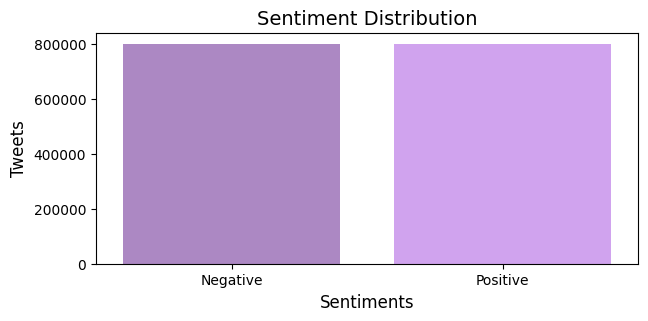

<Figure size 640x480 with 0 Axes>

In [11]:
# Positive & Negative Data
plt.figure(figsize=(7,3))
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')
sns.countplot(data=df, x='sentiment', palette=[colors[7], colors[9]])
plt.xlabel("Sentiments", size=12)
plt.ylabel('Tweets', size=12)
plt.title("Sentiment Distribution", size=14)

plt.savefig("../figures/Sentiment_Distribution.png",bbox_inches='tight')
plt.show()
plt.clf()

In [12]:
####Text Processing

# Random Text Sample Analysis
random_index = [random.randint(0, df.shape[0]) for i in range(10)]
for i in df['text'].loc[random_index]:
    print(i)

@mitchelmusso mitchel! please please come to az! i would come see you do anything here! 
@TimothyH2O uhmm i dont know what youre referring to, underwear or the breakup, but i guess both of them were that bad...  lulz
enjoying a nice cold cider lolly 
Listening to if the moon fell down tonight 
@leslietane hmmm weird, not sure, sorry 
something that makes me happy doing the hoedown throwdown with my lil cuz gosh i love you kaitlin!  not feeling too good right now.
I'm am super sad that Team USA lost.   Go Clay!
@LanceMannion A gorgeous day indeed! Thank you kindly and may you also delight in the day. 
My cutie 13 month godson took his first steps this weekend @ my house 
watchin that good ol sunday best!...i hope my girl jessica reedy wins with her jazzin it up self!  lol


In [13]:
###Data Cleansing
# All Patterns
mention_pattern = r'@\S+|#\S+'  # Pattern to match mentions (words starting with @ and #)
url_pattern = r"https?:(?:www\.)?\S+"  # Pattern to match URLs (starting with http or https)
non_alphanumeric_pattern = r"[^A-Za-z0-9\s]+"  # Pattern to match non-alphanumeric characters (including punctuation)

In [14]:
# Data Cleaning Function 
def data_cleaning(text):
    # Lowercasing 
    lower_text = str.lower(text)
    
    # Removing all unnecessary data 
    clean_text = re.sub(mention_pattern + '|' + url_pattern + '|' + non_alphanumeric_pattern, ' ', lower_text)
    
    return clean_text

In [15]:
# Performing Data Cleaning
df['text'] = df['text'].apply(data_cleaning)

In [16]:
###Tokenization

from tqdm import tqdm

tqdm.pandas()
nltk.download('punkt_tab')

# Apply word_tokenize with a progress bar
df['tokenized text'] = df['text'].progress_apply(lambda document: word_tokenize(document.strip()))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Billaaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 1600000/1600000 [05:05<00:00, 5241.06it/s]


In [17]:
nltk.download('stopwords')

# Getting list of stopwords
stop_words = set(stopwords.words('english'))

# Removing all Stopwords
df['clean_tokens'] = df['tokenized text'].progress_apply(lambda tokens: [token for token in tokens if token not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Billaaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1600000/1600000 [00:15<00:00, 103422.10it/s]


In [18]:
# Appling Lemmatization on Clean Tokens
lemmatizer = WordNetLemmatizer()

# Applying Lemmatization
df['lemmatized text'] = df['clean_tokens'].progress_apply(lambda tokens: ' '.join([lemmatizer.lemmatize(token, pos='v') for token in tokens]))

100%|██████████| 1600000/1600000 [02:18<00:00, 11519.15it/s]


In [19]:
df.head(100)

,sentiment,text,tokenized text,clean_tokens,lemmatized text
0,Negative,awww that s a bummer you shoulda got ...,"[awww, that, s, a, bummer, you, shoulda, got, ...","[awww, bummer, shoulda, got, david, carr, thir...",awww bummer shoulda get david carr third day
1,Negative,is upset that he can t update his facebook by ...,"[is, upset, that, he, can, t, update, his, fac...","[upset, update, facebook, texting, might, cry,...",upset update facebook texting might cry result...
2,Negative,i dived many times for the ball managed to ...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...",dive many time ball manage save 50 rest go bound
3,Negative,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]",whole body feel itchy like fire
4,Negative,no it s not behaving at all i m mad why a...,"[no, it, s, not, behaving, at, all, i, m, mad,...","[behaving, mad, see]",behave mad see
...,...,...,...,...,...
95,Negative,strider is a sick little puppy,"[strider, is, a, sick, little, puppy]","[strider, sick, little, puppy]",strider sick little puppy
96,Negative,so rylee grace wana go steve s party or not s...,"[so, rylee, grace, wana, go, steve, s, party, ...","[rylee, grace, wana, go, steve, party, sadly, ...",rylee grace wana go steve party sadly since ea...
97,Negative,hey i actually won one of my bracket pools t...,"[hey, i, actually, won, one, of, my, bracket, ...","[hey, actually, one, bracket, pools, bad, one,...",hey actually one bracket pool bad one money
98,Negative,you don t follow me either and i work for ...,"[you, don, t, follow, me, either, and, i, work...","[follow, either, work]",follow either work


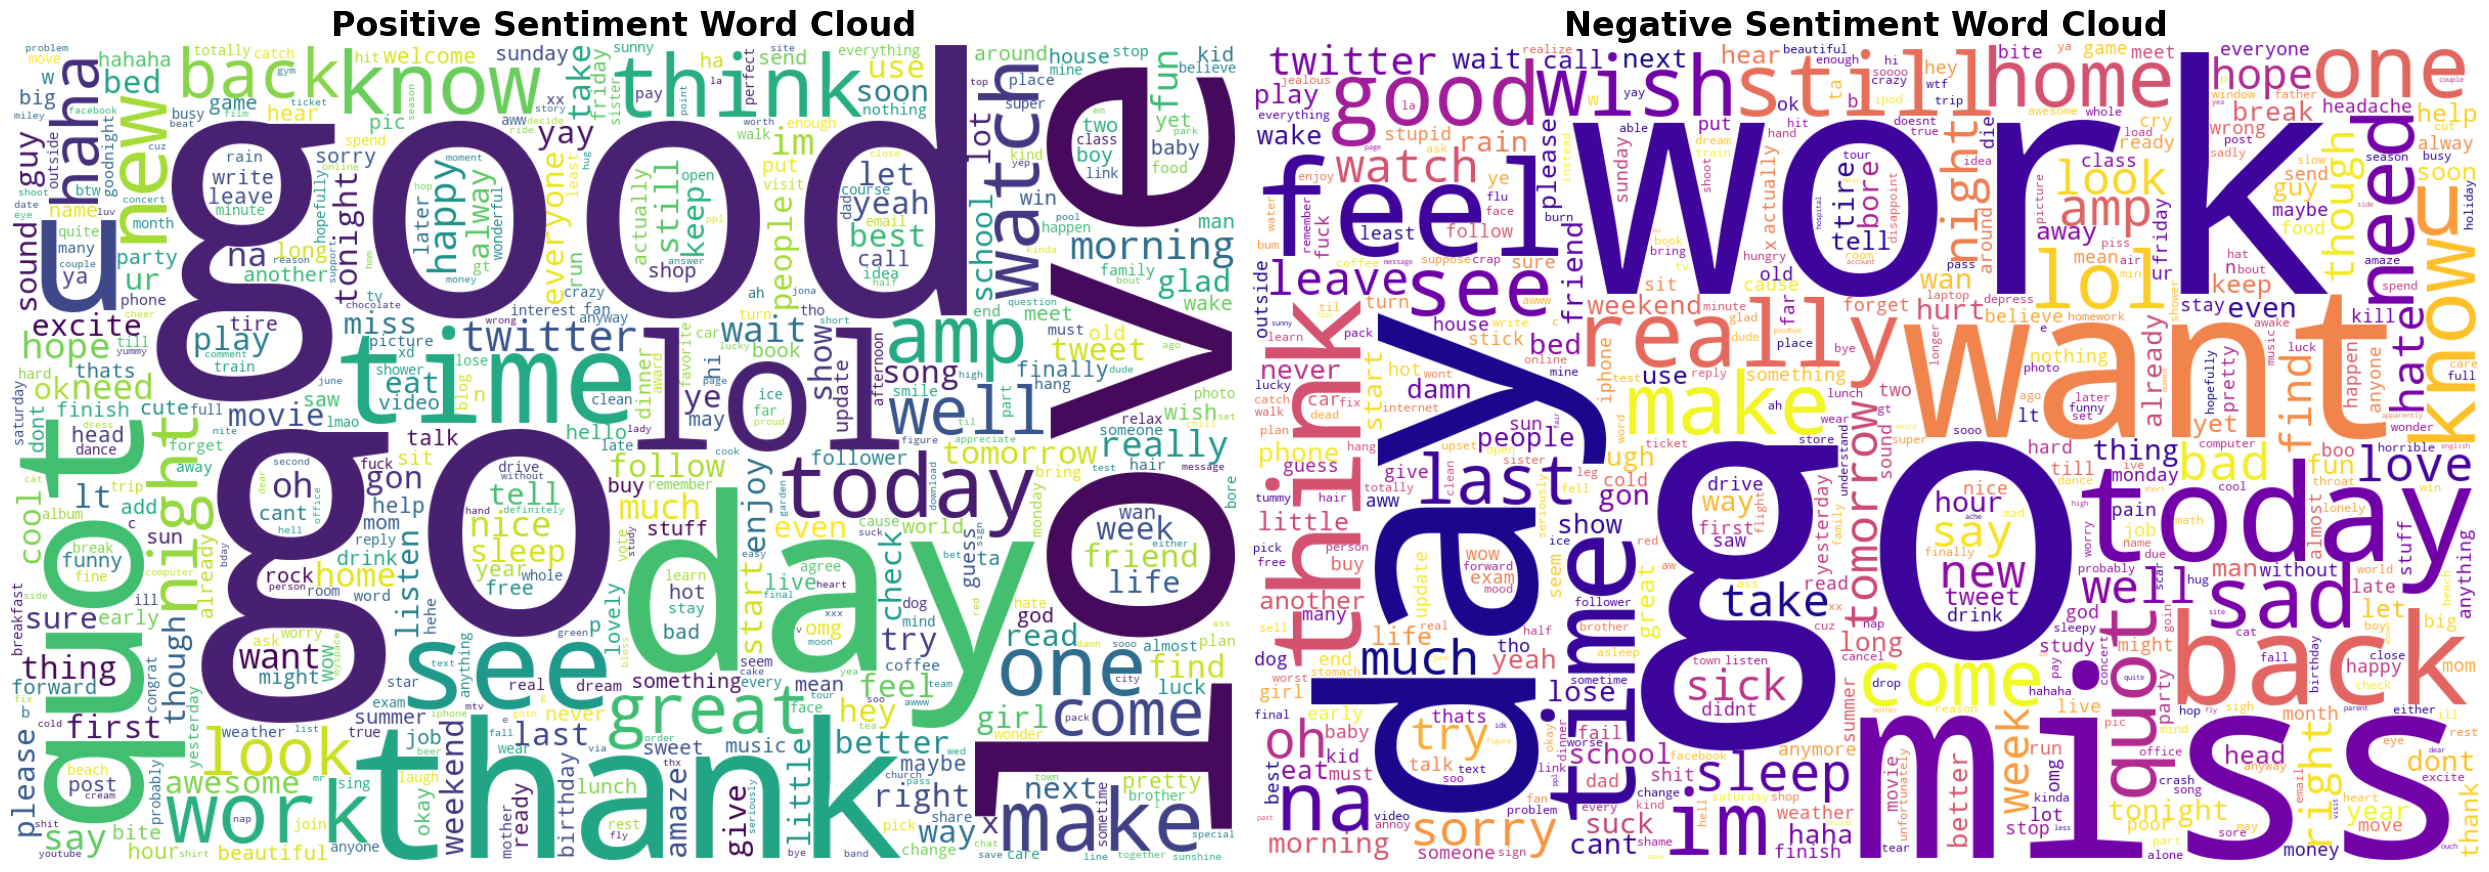

In [20]:
# Filter out positive and negative sentiment data
positive = df[df['sentiment'] == 'Positive']['lemmatized text']
negative = df[df['sentiment'] == 'Negative']['lemmatized text']

# Combine text data into single strings
positive_data = " ".join(positive)
negative_data = " ".join(negative)

# Create WordCloud objects
wc_positive = WordCloud(max_words=500, width=1200, height=800, background_color='white', colormap='viridis',
              contour_color='black', contour_width=1, collocations=False, random_state=42).generate(positive_data)

wc_negative = WordCloud(max_words=500, width=1200, height=800, background_color='white', colormap='plasma',
              contour_color='black', contour_width=1, collocations=False, random_state=42).generate(negative_data)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Plot positive sentiment word cloud
axes[0].imshow(wc_positive, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Positive Sentiment Word Cloud", fontsize=24, fontweight='bold')

# Plot negative sentiment word cloud
axes[1].imshow(wc_negative, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Negative Sentiment Word Cloud", fontsize=24, fontweight='bold')

plt.tight_layout()
plt.savefig("../figures/wordCloud.png",bbox_inches='tight')
plt.show()

In [21]:
# Creating new features
df['no_of_charcters'] = df['lemmatized text'].progress_apply(len)
df['no_of_words'] = df['lemmatized text'].progress_apply(lambda document: word_tokenize(document)).apply(len)

100%|██████████| 1600000/1600000 [04:02<00:00, 6587.44it/s]


In [22]:
df.head()

,sentiment,text,tokenized text,clean_tokens,lemmatized text,no_of_charcters,no_of_words
0,Negative,awww that s a bummer you shoulda got ...,"[awww, that, s, a, bummer, you, shoulda, got, ...","[awww, bummer, shoulda, got, david, carr, thir...",awww bummer shoulda get david carr third day,44,8
1,Negative,is upset that he can t update his facebook by ...,"[is, upset, that, he, can, t, update, his, fac...","[upset, update, facebook, texting, might, cry,...",upset update facebook texting might cry result...,69,11
2,Negative,i dived many times for the ball managed to ...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...",dive many time ball manage save 50 rest go bound,48,10
3,Negative,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]",whole body feel itchy like fire,31,6
4,Negative,no it s not behaving at all i m mad why a...,"[no, it, s, not, behaving, at, all, i, m, mad,...","[behaving, mad, see]",behave mad see,14,3


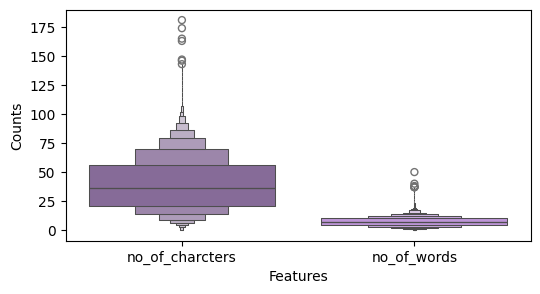

In [23]:
# Plotting Boxplot
plt.figure(figsize=(6,3))
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')
sns.boxenplot(df[['no_of_charcters', 'no_of_words']], palette=[colors[5], colors[8]])
plt.xlabel("Features")
plt.ylabel("Counts")
plt.savefig("../figures/features.png",bbox_inches='tight')
plt.show()

In [24]:
# Removing Outliers
df = df[(df['no_of_charcters']<100) & (df['no_of_words']<20)]

In [25]:
df.to_csv('../Data/prep&clean_dataset.csv')